In [1]:
class CrossWord:
    
    def __init__(self):
        self.constraint_checks = 0
        self.words = {
            "AFT", "ALE", "EEL", "HEEL",
            "HIKE", "HOSES", "KEEL", "KNOT",
            "LASER", "LEE", "LINE", "SAILS",
            "SHEET", "STEER", "TIE"
        }
        
        self.vars = {
            "1A": "", "2D": "", "3D": "", "4A": "", 
            "5D": "", "6D": "", "7A": "", "8A": ""
        }
        
                
        self.length_constraints = {
            "1A": 5, "2D": 5, "3D": 5, "4A": 4, 
            "5D": 4, "6D": 3, "7A": 3, "8A": 5
        }
       
        self.intersect_constraints = {
            "1A": [("1A", 2, "2D", 0), ("1A", 4, "3D", 0)], 
            "2D": [("2D", 0, "1A", 2), ("2D", 2, "4A", 1), 
                   ("2D", 3, "7A", 0), ("2D", 4, "8A", 2)],
            "3D": [("3D", 0, "1A", 4), ("3D", 2, "4A", 3), 
                   ("3D", 3, "7A", 2), ("3D", 4, "8A", 4)],
            "4A": [("4A", 1, "2D", 2), ("4A", 2, "5D", 0), ("4A", 3, "3D", 2)],
            "5D": [("5D", 0, "4A", 2), ("5D", 1, "7A", 1), ("5D", 2, "8A", 3)],
            "6D": [("6D", 1, "8A", 0)],
            "7A": [("7A", 0, "2D", 3), ("7A", 1, "5D", 1), ("7A", 2, "3D", 3)], 
            "8A": [("8A", 0, "6D", 1), ("8A", 2, "2D", 4), 
                   ("8A", 3, "5D", 2), ("8A", 4, "3D", 4)]
        }
        
        self.domains = {
            k: [word for word in self.words if len(word) == self.length_constraints[k]] 
            for k, v in self.vars.items()
        }

    def check_constraints(self, assignment: dict) -> bool:
        self.constraint_checks += 1
        fresh_assign = {k: v for k, v in assignment.items() if v != ""}
        
#         if True in [len(val) != self.length_constraints[key] 
#                for key, val in fresh_assign.items()]:
#             return False
            
        for key, val in fresh_assign.items():
            for _, i1, v2, i2 in self.intersect_constraints[key]:
                if fresh_assign.get(v2, None) is not None \
                  and val[i1] != fresh_assign[v2][i2]:
                    return False

        return True

In [2]:
def recursive_backtracking(env, assignment, expanded=0, verbose=False):
    # Locate an empty assignment
    unassigned = None
    for key, val in assignment.items():
        if val == "":
            unassigned = key
            break
            
    if unassigned is None: 
        return assignment, expanded
    
    for word in env.domains[unassigned]:
        # Select a potential assignment
        assignment[unassigned] = word
        
        # Check assignments validity
        if not env.check_constraints(assignment):
            continue
        
        # lock in current value and expand other nodes
        result, expanded = recursive_backtracking(env, {k: v for k, v in assignment.items()}, expanded + 1)
        if result is not None:
            if verbose:
                print("Number of backtracks", expanded)
            return result, expanded
        
    return None, expanded

In [3]:
def arc_consistency(env, verbose=False):
    constraint_checks = 0
    domains = {
        k: [word for word in env.words if len(word) == env.length_constraints[k]] 
        for k, v in env.vars.items()
    }
    
    container = [x for k, v in env.intersect_constraints.items() for x in v]
    
    while container != []:
        constraint_checks += 1
        n1, i1, n2, i2  = container.pop(0)
        
        # Revise the CSP
        prior_len = len(domains[n1])
        avail_letters1 = set(word[i1] for word in domains[n1])
        avail_letters2 = set(word[i2] for word in domains[n2])
        result = avail_letters1.intersection(avail_letters2)
        
        # Update the domain based on the revision
        domains[n1] = [word for word in domains[n1] if word[i1] in result]
        
        if domains[n1] == []:  # No solution exists
            return None
        elif len(domains[n1]) != prior_len:
            # If domain changes, reconsider constraints for neighbouring nodes
            for n, i, m, j in env.intersect_constraints[n1]:
                if m != n2:
                    # We shedule neighbour m to be updated with 
                    # the new domain of n (our current node)
                    container.append((m, j, n, i))  
    
    if verbose:
        print(f"Number of arc constraint checks: {constraint_checks}")   
        
    return domains

In [4]:
env = CrossWord()

recursive_backtracking(env, {k: v for k, v in env.vars.items()}, verbose=True)
arc_consistency(env, verbose=True)

print("Number of backtracking constraint checks", env.constraint_checks)

Number of backtracks 24
Number of arc constraint checks: 54
Number of backtracking constraint checks 102


In [5]:
import time

samples = 1000
env = CrossWord()

start = time.time()
for i in range(samples):
    recursive_backtracking(env, {k: v for k, v in env.vars.items()})

print("backtracking", (time.time() - start) / samples)

start = time.time()
for i in range(samples):
    arc_consistency(env)

print("arc", (time.time() - start) / samples)

backtracking 0.00018901419639587403
arc 9.927296638488769e-05


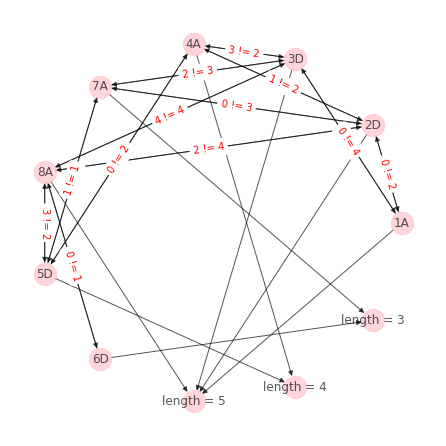

In [6]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot
from matplotlib import pyplot as plt

edge_labels = {(x[0], x[2]): f"{x[1]} != {x[3]}" 
               for const in env.intersect_constraints.values() 
               for x in const}
edges = [[edge[0], edge[1]] for edge in edge_labels.keys()] \
    + [[key, f"length = {val}"] for key, val in env.length_constraints.items()]

G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.circular_layout(G)
plt.figure(figsize=(6, 6))
nx.draw(G, pos, edge_color='black', width=1, linewidths=1, \
        node_size=500, node_color='pink' ,alpha=0.66, \
        labels={node: node for node in G.nodes()})

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.axis('off')
plt.show()
# plt.savefig('constraints.png')